In [5]:
#Import all library needed
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from scipy import stats
#import scikit_posthocs as sp
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Uji Asumsi Klasik pada Regresi Linier
Regresi Linier memiliki 5 asumsi yang perlu dipenuhi. Asumsi ini sebenarnya wajib dalam teori ilmu statistika, namun dalam praktik machine learning proses ini terkadang diabaikan karena ketidaktahuan. Uji ini berfungsi untuk ketepatan estimasi dan menjauhkan dari bias

1. Hubungan (korelasi) linier antara feature dan label
2. Uji Normalitas
3. Tidak terjadi Heteroskedastisitas
4. Tidak terdapat multikolinearitas (**untuk regresi berganda**)
5. Tidak terdapat autokorelasi


Sumber buku "Multivariate data analysis" by Hair

In [6]:
!wget -O Startups.csv https://raw.githubusercontent.com/Handit14/OrbitFutureAcademy_KampusMerdeka/main/Materi/Startups.csv

--2021-11-13 13:56:23--  https://raw.githubusercontent.com/Handit14/OrbitFutureAcademy_KampusMerdeka/main/Materi/Startups.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2387 (2.3K) [text/plain]
Saving to: ‘Startups.csv’

Startups.csv        100%[===================>]   2.33K  --.-KB/s    in 0s      

2021-11-13 13:56:23 (35.6 MB/s) - ‘Startups.csv’ saved [2387/2387]



In [7]:
reglin = pd.read_csv('Startups.csv')
reglin.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [8]:
reglin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


## 1. Hubungan Linier antara tiap feature dengan label (X dan Y)
Bisa menggunakan plot

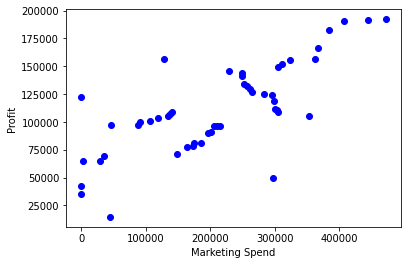

In [9]:
plt.scatter(reglin['Marketing Spend'], reglin['Profit'], color='blue')
plt.xlabel("Marketing Spend")
plt.ylabel("Profit")
plt.show()

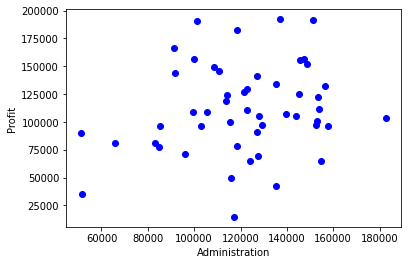

In [10]:
plt.scatter(reglin['Administration'], reglin['Profit'], color='blue')
plt.xlabel("Administration")
plt.ylabel("Profit")
plt.show()

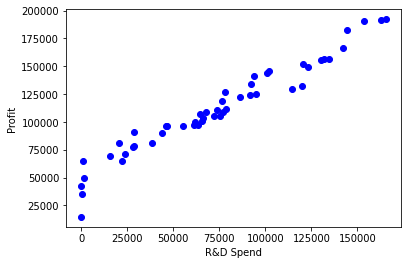

In [11]:
plt.scatter(reglin['R&D Spend'], reglin['Profit'], color='blue')
plt.xlabel("R&D Spend")
plt.ylabel("Profit")
plt.show()

Terlihat bahwa R&D dan marketing spend plotnya masih cenderung membentuk garis yang menunjukkan masing-masing memiliki hubungan yang kuat dengan profit, sementara administration plotnya terlihat berpencar sehingga tidak ada hubungan linier dengan profit. Jadi kedepannya variabel yang kita gunakan sebagai feature adalah R&D dan marketing spend.

## 2. Uji normalitas
Disini yang kita uji adalah normalitas residual (errornya). Mengapa? karena menurut sifat distribusi normal, kalo errornya normal dan modelnya linier maka koefisien regresinya juga berdistribusi normal (terhindar dari bias outlier).

In [12]:
features = ['R&D Spend','Marketing Spend']                   #x1 = R&D, x2 =  Marketing
X = reglin[features].values
Y = reglin.Profit
lin_reg = LinearRegression()
lin_reg.fit(X, Y)

#print(f'Coefficients: {lin_reg.coef_}')
#print(f'Intercept: {lin_reg.intercept_}')
#print(f'R^2 score: {lin_reg.score(X, Y)}')

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


KstestResult(statistic=0.11368328760156177, pvalue=0.5101193088472268)


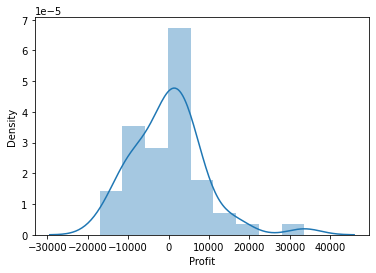

In [13]:
y_pred = lin_reg.predict(X)
err = y_pred - Y                        #error/residualnya
sns.distplot(err)                       #membuat plot histogramnya

z_er = stats.zscore(err)
norm_er = stats.kstest(z_er, 'norm', )  #uji kolmogorov-smirnov, salah 1 cara uji normalitas
print(norm_er)

Ho : data = berdistribusi normal

Ha : data tidak berdistribusi normal

Karena pvaiue > 0.05, maka Ho diterima. Gambar histogram yang membentuk lonceng pun mendukung bahwa datanya sudah berdistribusi normal.

## 3. Tidak terjadi Heteroskedastisitas

Homoskedastisitas  adalah  kondisi ketika  nilai  residu/error  pada  tiap  nilai  prediksi  bervariasi  dan  variasinya  cenderung konstan. Lawan dari homoskedastisitas adalah heteroskedastisitas, dimana error cenderung berubah dan malah berkorelasi dengan prediksinya. Jika ini terjadi tentu menunjukkan bahwa prediksi ini memiliki suatu bias tertentu. Untuk mengeceknya kita bisa melihat plotnya

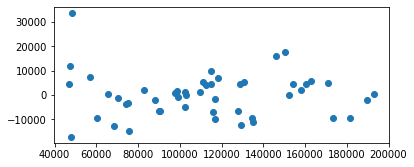

In [14]:
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(y_pred, err)

Terlihat plot errornya berada di sekitar angka yang sama meski nilai prediksinya bertambah, artinya nilai prediksi kita tidak terganggu oleh errornya

Berikut adalah contoh plot jika terjadi heteroskedastisitas, plotnya membentuk pola tertentu yang menunjukkan bahwa nilai prediksinya masih berkorelasi dengan error sehingga nilai prediksi kita masih terganggu oleh nilai errornya:

![alt text](https://drive.google.com/uc?id=1VX4X3w95lBlTphDXg9Ez2Rv9Ky3tUz8e)

Cara lain untuk menguji homoskedastisitas: using Glejser Test, White test, Breusch-Pagan test

## 4. Tidak terjadi multikolinearitas (regresi berganda)
Multokolinearitas maksudnya adalah hubungan yang kuat antar feature. Regresi linier mengasumsikan bahwa feature-featurenya tidak saling berhubungan. Tentu saja ini hanya berlaku untuk regresi linier berganda (yang featurenya lebih dari 1). Salah 1 cara mengujinya adalah nilai VIF.

In [15]:
vif = [variance_inflation_factor(X, i) for i in range(len(X.T))]
pd.DataFrame({'VIF': vif[0:]}, index=features).T

,R&D Spend,Marketing Spend
VIF,7.156216,7.156216


Some papers argue that a VIF<10 is acceptable, but others says that the limit value is 5.
- "10" as the maximum level of VIF (Hair et al., 1995)
- "5" as the maximum level of VIF (Ringle et al., 2015)


Jadi berdasarkab kriteria Hair tidak terjadi kolinearitas, tetapi kalo berdasarkan kriteria Ringle masih terjadi kolinearitas. Disini kita menggunakan teori Hair.

## 5. Tidak terjadi autokorelasi
Autokorelasi adalah hubungan yang erat antar entry, misalnya antara data ke 4 dengan ke 5, data ke-6 dengan ke-7, dll. Ini juga harus dihindari dalam regresi linier. 

In [16]:
X_constant = sm.add_constant(X)                #Ingat lagi x1 = R&D, x2 =  Marketing
lin_reg = sm.OLS(Y,X_constant).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     450.8
Date:                Sat, 13 Nov 2021   Prob (F-statistic):           2.16e-31
Time:                        13:56:29   Log-Likelihood:                -525.54
No. Observations:                  50   AIC:                             1057.
Df Residuals:                      47   BIC:                             1063.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.698e+04   2689.933     17.464      0.000    4.16e+04    5.24e+04
x1             0.7966      0.041     19.266      0.000       0.713       0.880
x2             0.0299      0.016      1.927      0.060      -0.001       0.061
==============================================================================
Omnibus:                       14.677   Durbin-Watson:                   1.257
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.161
Skew:                          -0.939   Prob(JB):                     2.54e-05
Kurtosis:                       5.575   Cond. No.                     5.32e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.32e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

![alt text](https://drive.google.com/uc?id=1iz2TAjhoquwj6nztVU9poi79-8-Bkda_)


Download DW table: https://www3.nd.edu/~wevans1/econ30331/Durbin_Watson_tables.pdf. Karena nilai dw = 1.257 < dL= 1.462, maka disini tidak ada masalah autokorelasi

## Mengevaluasi hasil regresi linier
Kelebihan dari regresi linier dari model machine learning lainnya adalah mudah diinterpretasi dan dapat memberikan insight berapa besar pengaruh suatu feature terhadap labelnya. Berikut interpretasi jika menggunakan tingkat kepercayaan 95% :


**1.   Signifikansi pengaruh feature secara sendiri-sendiri.** 
Perhatikan nilai di kolom "P>|t|" yang menunjukkan pvalue dari x1 (R&D) dan x2 (marketing). Terlihat bahwa pvalue x1 < 0.05 dan pvalue x2 > 0.05. Artinya pengaruh R&D terhadap profit perusahaan signifikan sementara pengaruh marketing belum signifikan. 

**2. Besar pengaruh tiap feature.** Perhatikan kolom "coef", pada x1 (R&D) nilainya 0.7966, artinya setiap kenaikan perusahaan menaikkan kinerja R&D 1 level saja mampu meningkatkan profit perusahaan sebesar 0.7966. Sementara koefisien x2 (marketing) sebesar 0.0299. Artinya selama ini pengaruh marketing terhadap profit hanya 0.0299.

**3.   Pengaruh kedua variabel secara bersamaan.** Nilai Prob (F-statistic)=	2.16x 10^(-31). Nilai ini menunjukkan signifikansi pengaruh kedua feature secara bersamaan, karena nilainya < 0.05, maka dapat disimpulkan pengaruh keduanya secara bersamaan terhadap labelnya signifikan.

**4. Evaluasi keseluruhan.** Model ini memiliki R2 sebesar 0.95. Artinya 95% variasi dari keseluruhan profit sudah tergambar dalam model ini, sementara sisanya yaitu 5% dipengaruhi faktor lain yang belum ada di model ini.  R2 merupakan metric yang digunakan untuk mengevaluasi model regresi linier yang bagus



Open question (bisa didiskusikan): jika kamu adalah bos perusahaan, melihat hasil ini apakah kebijakan yang akan kamu ambil? mengucurkan lebih banyak dana pada tim R&D? atau mengevaluasi tim marketing yang ternyata kerjanya belum signifikan?


# Naive Bayes

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from collections import Counter


In [18]:
headers = ['Age', 'Delivery_Nbr', 'Delivery_Time', 'Blood_Pressure', 'Heart_Problem', 'Caesarian']
# read in cars dataset
data = pd.read_csv('https://raw.githubusercontent.com/PacktWorkshops/The-Data-Science-Workshop/master/Chapter06/Dataset/caesarian.csv.arff', names=headers, index_col=None, skiprows=15)

In [19]:
data

,Age,Delivery_Nbr,Delivery_Time,Blood_Pressure,Heart_Problem,Caesarian
0,22,1,0,2,0,0
1,26,2,0,1,0,1
2,26,2,1,1,0,0
3,28,1,0,2,0,0
4,22,2,0,1,0,1
...,...,...,...,...,...,...
75,27,2,1,1,0,0
76,33,4,0,1,0,1
77,29,2,1,2,0,1
78,25,1,2,0,0,1


In [20]:
data.isnull().sum()

Age               0
Delivery_Nbr      0
Delivery_Time     0
Blood_Pressure    0
Heart_Problem     0
Caesarian         0
dtype: int64

In [21]:
# Variabel independen
x = data.iloc[:, :5]

# Variabel dependen
y = data.iloc[:, 5]

In [22]:
print(x, y)

    Age  Delivery_Nbr  Delivery_Time  Blood_Pressure  Heart_Problem
0    22             1              0               2              0
1    26             2              0               1              0
2    26             2              1               1              0
3    28             1              0               2              0
4    22             2              0               1              0
..  ...           ...            ...             ...            ...
75   27             2              1               1              0
76   33             4              0               1              0
77   29             2              1               2              0
78   25             1              2               0              0
79   24             2              2               1              0

[80 rows x 5 columns] 0     0
1     1
2     0
3     0
4     1
     ..
75    0
76    1
77    1
78    1
79    0
Name: Caesarian, Length: 80, dtype: int64


In [23]:
Counter(y)

Counter({0: 34, 1: 46})

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [25]:
# Mengaktifkan/memanggil/membuat fungsi klasifikasi Naive Bayes
modelnb = GaussianNB()
# Memasukkan data training pada fungsi klasifikasi Naive Bayes
nbtrain = modelnb.fit(x_train, y_train)

In [26]:
# Menentukan hasil prediksi dari x_test
y_pred = nbtrain.predict(x_test)
y_pred

array([0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1])

In [27]:
confusion_matrix(y_test, y_pred)

array([[3, 3],
       [2, 8]])

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.50      0.55         6
           1       0.73      0.80      0.76        10

    accuracy                           0.69        16
   macro avg       0.66      0.65      0.65        16
weighted avg       0.68      0.69      0.68        16

